In [1]:
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from scipy.stats import norm, sem, t

%matplotlib inline
plt.style.use('seaborn')

In [2]:
def RunRandomForest(df, question, features, feature_subset):
    
    df['is_train'] = np.random.uniform(0, 1, len(df)) <= .50
    
    for ID in feature_subset.id:
    
        new_header = ID + 'feature'
        df[new_header] = pd.factorize(df[ID])[0]

    # Create two new dataframes, one with the training rows, one with the test rows
    train, test = df[df['is_train']==True], df[df['is_train']==False]

    # train[question] contains the results. Before we can use it,
    # we need to convert each result into a digit. 
    y = pd.factorize(train[question])[0]
    y_test = pd.factorize(test[question])[0]

    X = train[features]
    X_test = test[features]
    # Create a random forest classifier. By convention, clf means 'classifier'
    clf = RandomForestClassifier(n_estimators=24);

    # Train the classifier to take the training features and learn how they relate
    # to the training y (the species)
    clf.fit(X, y);

    # Apply the classifier we trained to the test data (which, remember, it has never seen before)
    pred_y_test = clf.predict(X_test);
    
    # Check accuracy of model on test data
    acc_test = accuracy_score(y_test, pred_y_test);
    
    # Check auroc against test date
    prob_y_test = clf.predict_proba(test[features]);
    prob_y_test = [p[1] for p in prob_y_test];
    auroc_test = roc_auc_score(y_test, prob_y_test);
    
    confusion = confusion_matrix(y_test,pred_y_test)/confusion_matrix(y_test,pred_y_test).sum()
    #print(confusion)

    # View a list of the features and their importance scores
    return train[features], clf.feature_importances_, acc_test, auroc_test, confusion

def RepeatedRandomForests(df, question, filename, feature_subset, iterations=100):
    
    locs = ((df[question] != 'Valid Skip') | (df[question] != 'NA')) 
    
    # Create a list of the feature column's names
    features = df[locs].columns[189:]

    importance_measures = np.zeros(len(features))
    
    accuracies = np.zeros(0);
    aurocs = np.zeros(0);
    
    confusion_mat = np.zeros((2,2));

    start = time.clock();

    for i in np.arange(0,iterations):
        
        trained, importance, acc, auroc, confusion = RunRandomForest(df, question, features, feature_subset);
    
        if i == 0:
            
            importance_measures = importance;
            accuracies = acc;
            aurocs = auroc;
            confusion_mat = confusion;
            
        else:
        
            importance_measures = np.vstack((importance_measures, importance));
            accuracies = np.vstack((accuracies,acc));
            aurocs = np.vstack((aurocs,auroc));
            confusion_mat = confusion_mat+confusion;

    confusion_mat = confusion_mat/iterations;
    time_elapsed = time.clock() - start;

    print(time_elapsed, 's')

    fd = open(filename,'ab')
    np.savetxt(fd, importance_measures, delimiter=',')
    fd.close()

    return trained, importance_measures, features, accuracies, aurocs, confusion_mat

def mean_confidence_interval(data, confidence=0.95):
    
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), sem(a)
    h = se * t._ppf((1+confidence)/2., n-1)
    return m, h

def checkFeature(factor):
    
    feature = rel_importance[factor]
    weights = np.ones_like(feature)/float(len(feature))

    fig = plt.figure(num=None, figsize=(4, 3), dpi=120, 
               facecolor='w', edgecolor='k')
    
    ax = fig.add_subplot(111)
    
    n, bins, patches = plt.hist(feature, 20, weights=weights,
                                facecolor='green', alpha=0.75)
    
    plt.title("Distribution for " + factor)
    plt.xlabel("Relative Importance")
    plt.ylabel("Frequency")
    ax.set_xlim((0,0.25))
    
def plotImportance(rel_importance, features, questions, question, iterations=100):
    
    fig = plt.figure(num=None, 
               figsize=(8, 16), 
               dpi=200, 
               facecolor='w', 
               edgecolor='k')

    ax = fig.add_subplot(111)

    importances = rel_importance.mean().values;
    mean, ci = mean_confidence_interval(rel_importance);
    indices = np.argsort(importances);
    
    tags = []
    colors = pd.DataFrame([]);

    for i in range(len(features)):

        tags.append(questions[questions['feature'] == features[indices][i]]['shortname'].values[0])

        if(questions[questions['feature'] == features[indices][i]]['influence'].values[0] == 'neg'):

            colors = colors.append(['r'], ignore_index=True)

        else:

            colors = colors.append(['g'], ignore_index=True)

    barlist = plt.barh(range(len(indices)), importances[indices], 
             color = colors[0], align='center',
             xerr = ci[indices])

    plt.yticks(range(len(indices)), tags)

    plt.xlabel('Relative Importance')
    plt.title('Important Features for ' + question)
    
    
def plotCumuluativeImportance(rel_importance, features, questions, iterations=100):
    
    importances = rel_importance.mean()
    mean, ci = mean_confidence_interval(rel_importance)
    indices = np.argsort(importances)[::-1]

    fig = plt.figure(num=None, 
                   figsize=(10, 3), 
                   dpi=120, 
                   facecolor='w', 
                   edgecolor='k')

    ax = fig.add_subplot(111)


    cumulative = np.cumsum(importances[indices])
    
    
    tags = []
    
    for i in range(len(features)):
        
        tags.append(questions[questions['feature'] == features[indices][i]]['shortname'].values[0])
    
    plt.errorbar(np.arange(0,len(cumulative)), cumulative, yerr=ci[indices])
    plt.plot([-1,0],[0,cumulative[0]],'-b')
    plt.title('Cumulative Importance')
    plt.ylabel('Importance (arb. units)')
    plt.xlabel('Feature')
    plt.xticks(range(len(cumulative)), tags, rotation=90);

In [3]:
folder='../../ComputationSurveyData/';
XLS = pd.ExcelFile(folder + 'LabeledComputationData.xlsx')
XLS2 = pd.ExcelFile(folder + 'CategorizedQuestions.xlsx')
df = XLS.parse('LabeledComputationData')
questions = XLS2.parse('Sheet1')

In [4]:
question = 'Q1';

output_folder = '../../ComputationSurveyAnalyzedData/';
output_file = 'TeachCompDept50000runs_24trees.csv';
filename = output_folder + output_file;
iterations = 50000;

feature_subset = questions[(questions['scale'] == 'department') & 
          (questions['qtype'] !='open') & 
          ((questions['context'] == 'support') | 
           (questions['context'] == 'resources') | 
           (questions['context'] == 'background') |
           (questions['context'] == 'program')) &
                           (questions['predictTeach'] == 'input') &
                           (questions['other'] != 'other')];

In [5]:
len(feature_subset)

45

In [7]:
trained, feature_importances, features, accuracies, aurocs, confusion_mat = RepeatedRandomForests(df, question, filename, feature_subset, iterations);
rel_importance = pd.read_csv(filename, names=trained);

3267.6547130000004 s


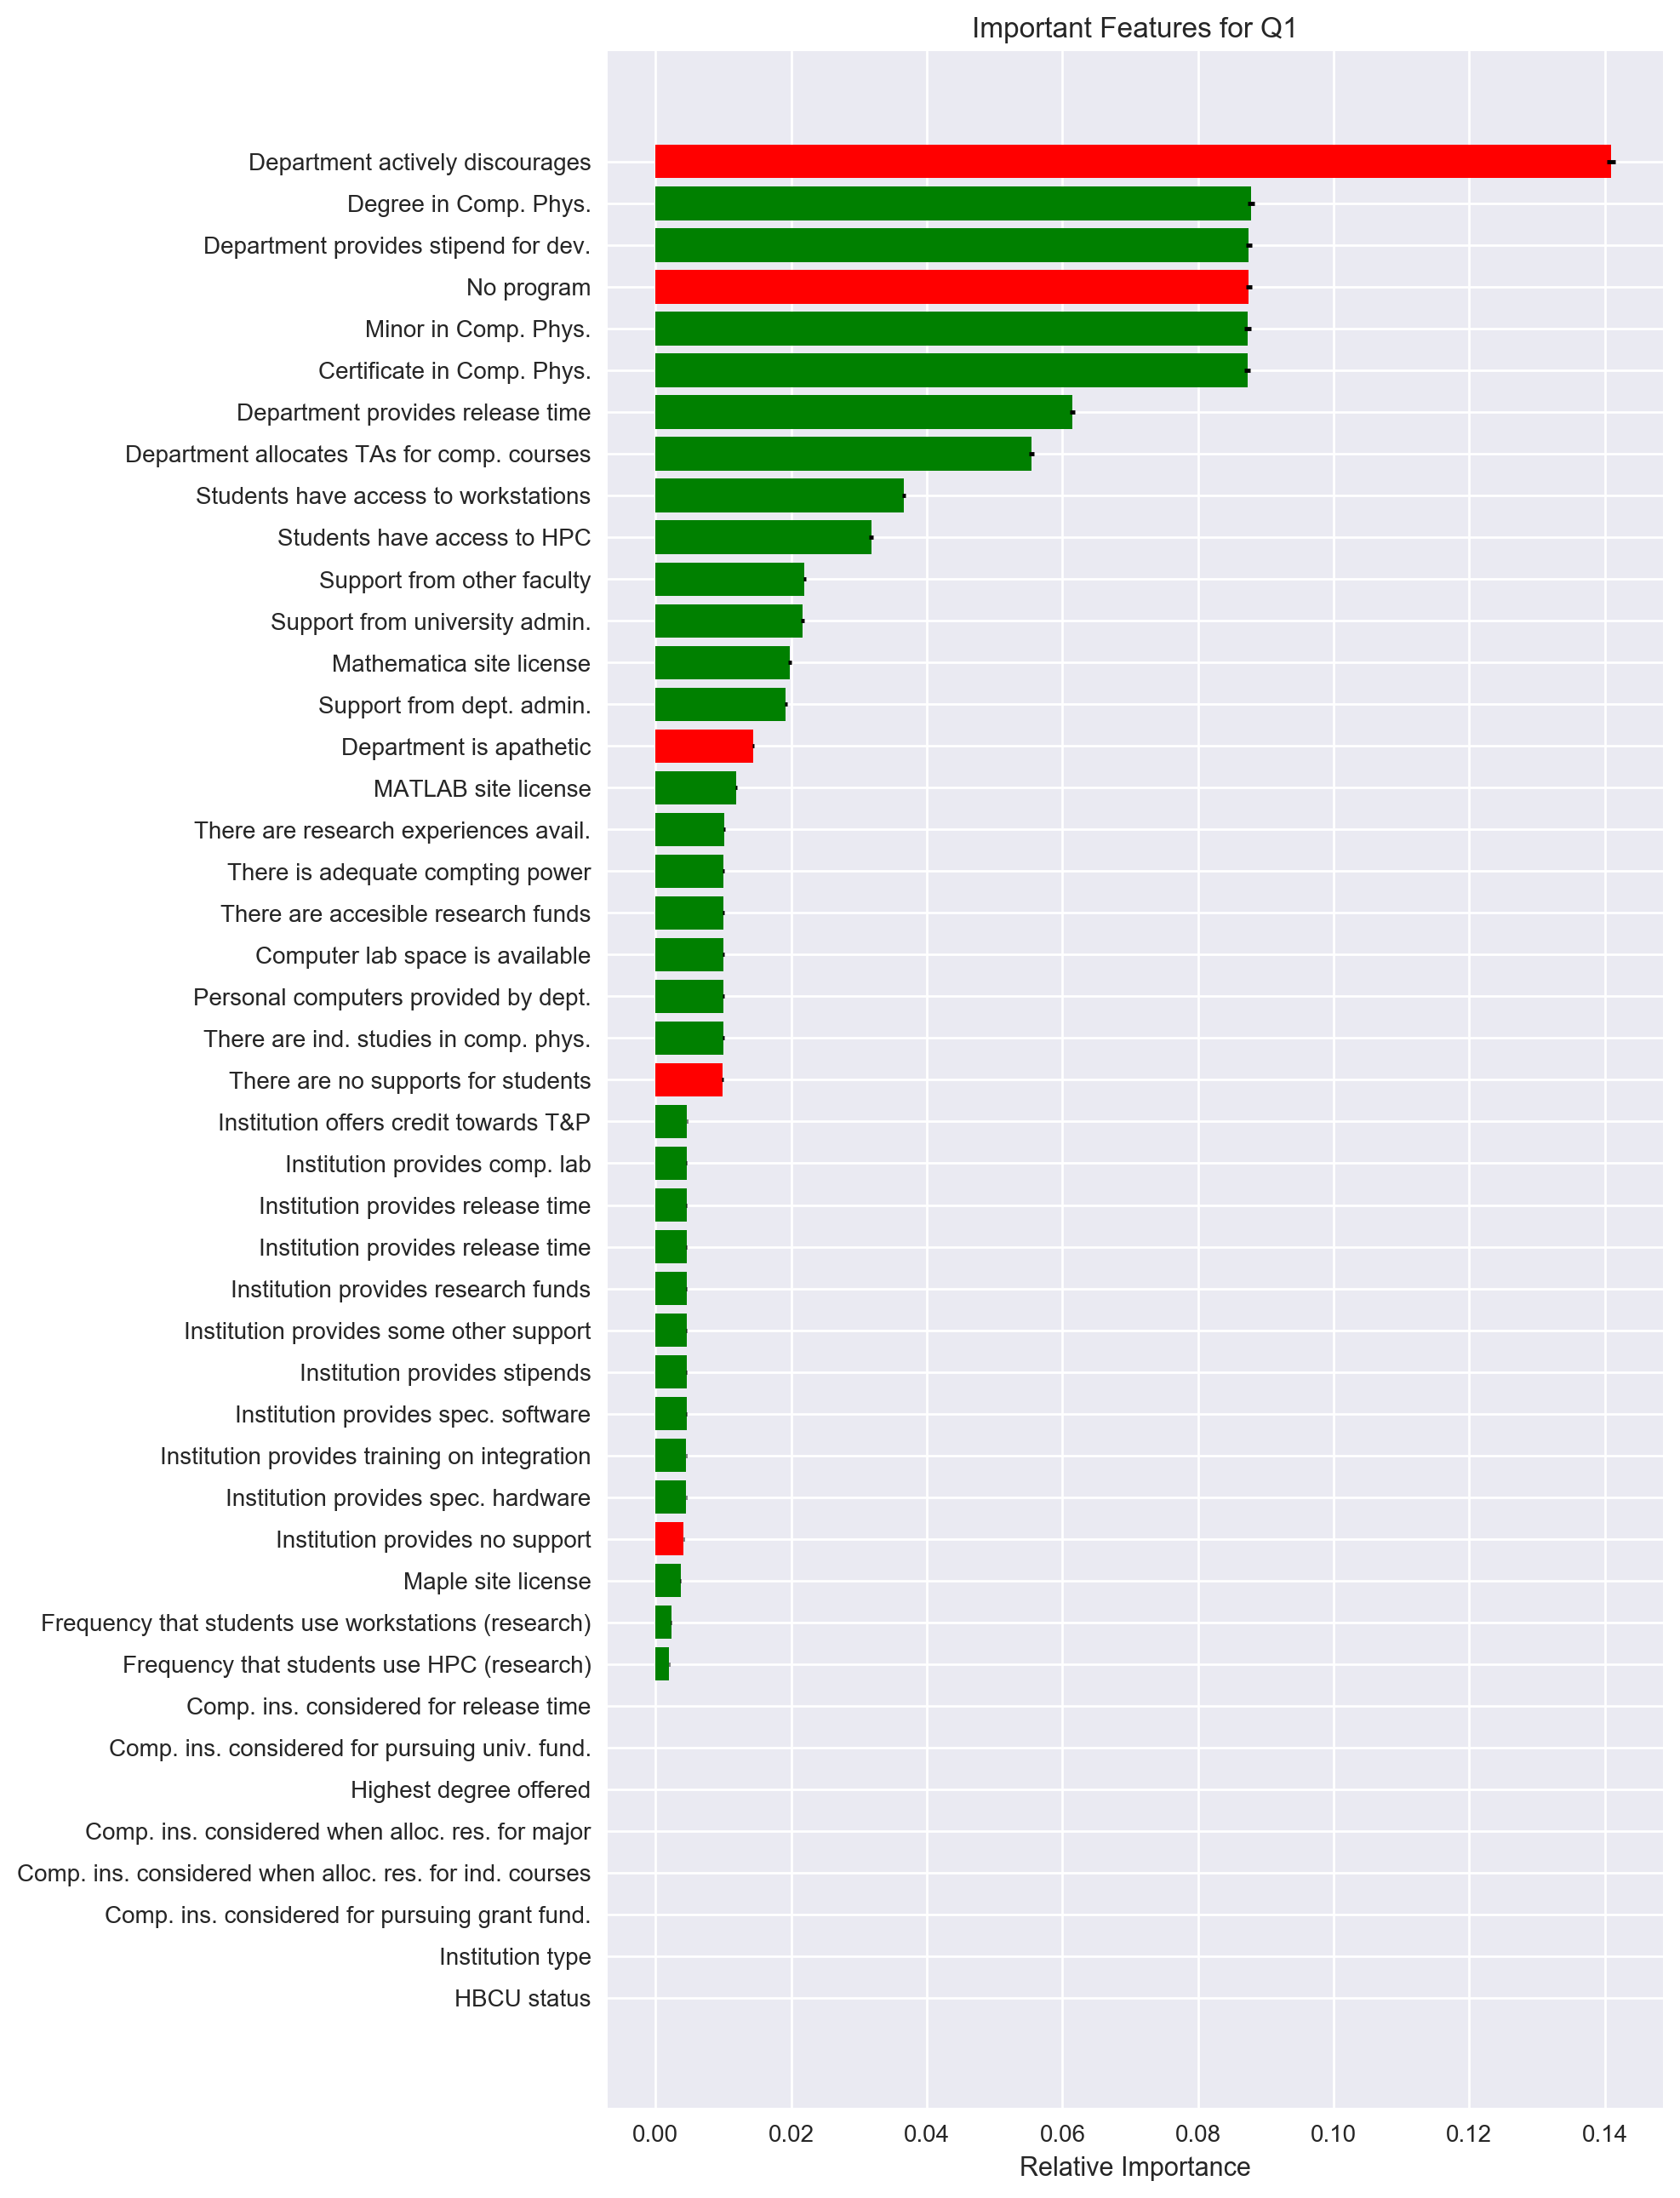

In [8]:
plotImportance(rel_importance, features, questions, question, iterations)

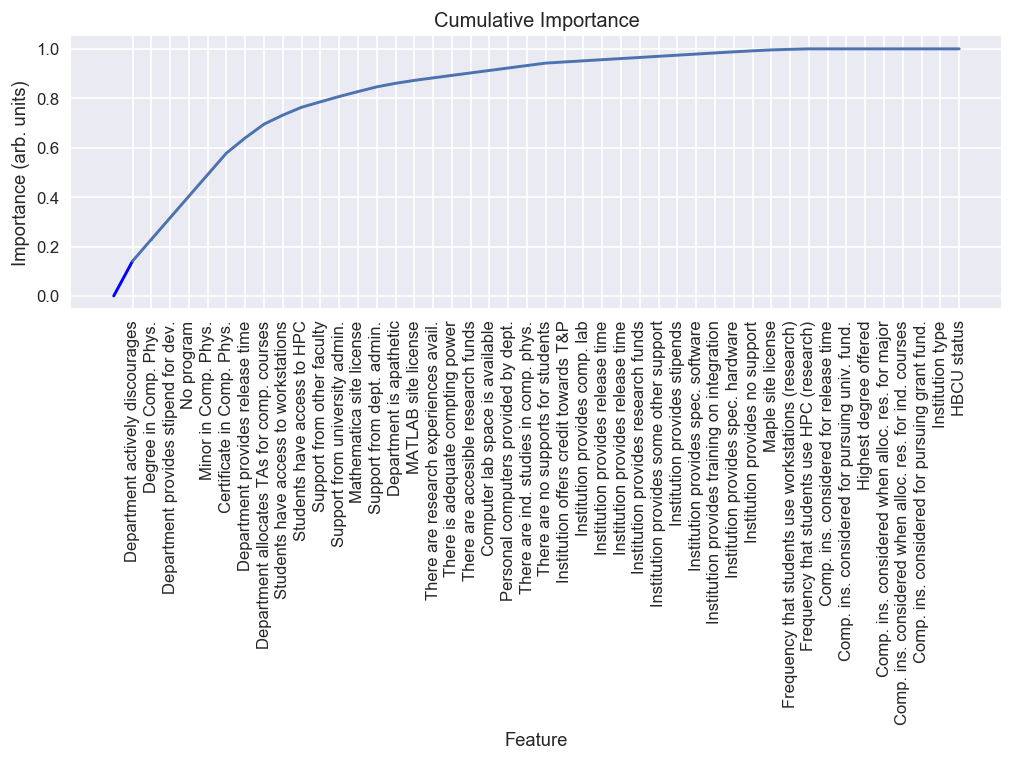

In [9]:
plotCumuluativeImportance(rel_importance, features, questions, iterations)

In [10]:
print('Mean Accuracy: ', accuracies.mean(), '\nMean AUROC: ', aurocs.mean())

Mean Accuracy:  0.963110579413 
Mean AUROC:  0.96312


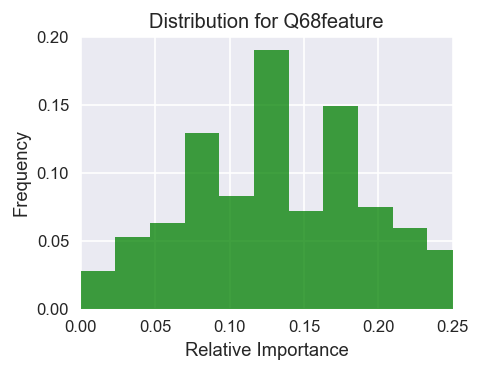

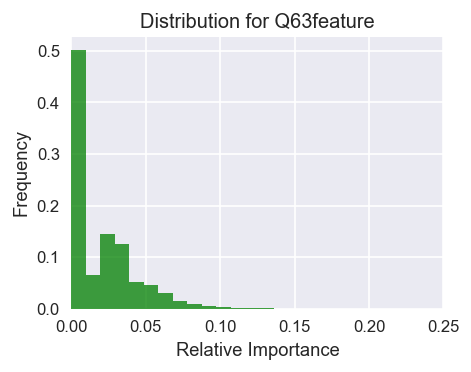

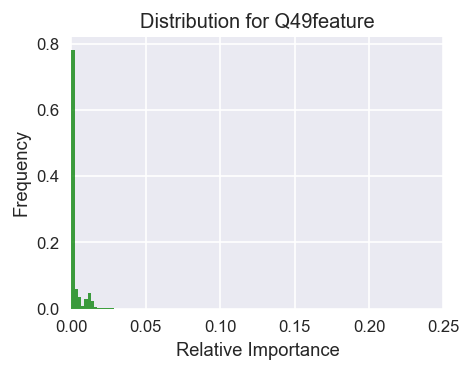

In [11]:
checkFeature('Q68feature')
checkFeature('Q63feature')
checkFeature('Q49feature')

In [12]:
confusion_mat

array([[ 0.38265235,  0.01848231],
       [ 0.01840711,  0.58045823]])